In [ ]:
import mlflow
import mlflow.sklearn
from matplotlib.pyplot import xlabel, ylabel, show, title, subplot,subplots_adjust
from numpy import percentile
from pandas import read_csv, DataFrame, concat
from seaborn import histplot
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier


In [21]:
dataframe = read_csv('../data/water_potability.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [22]:
dataframe['Potability'].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

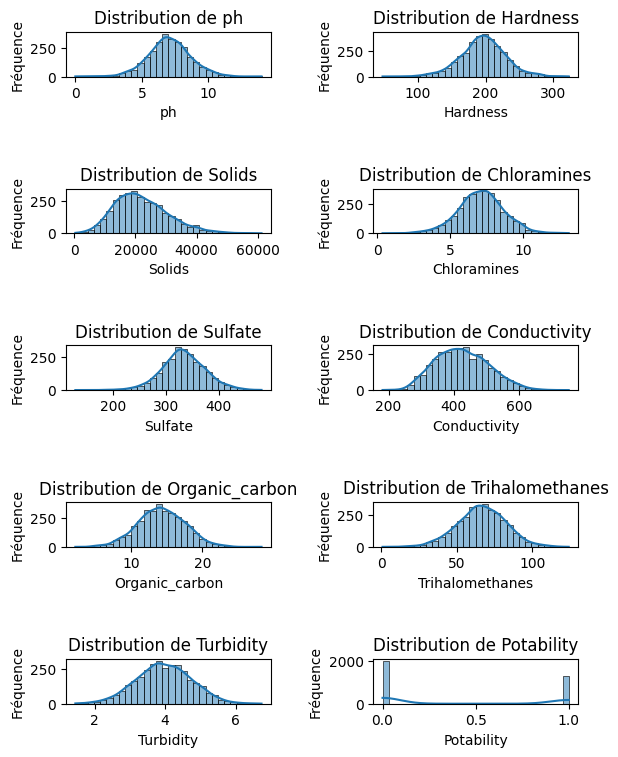

In [23]:

def distribution_by_column(dataframe: DataFrame, columns: list[str]) -> None:
    for index, feature in enumerate(columns, 1):
        subplot(5, 2, index)
        subplots_adjust(left = 0.1, top = 1.5, right = 0.9, bottom = 0.1, hspace = 2.5, wspace = 0.5)
        histplot(dataframe[feature], kde=True, bins=30, color="#1f77b4")
        title(f"Distribution de {feature}")
        xlabel(feature)
        ylabel("Fréquence")

    show()

distribution_by_column(dataframe, dataframe.columns)

In [24]:


def balance_dataframe(dataframe: DataFrame) -> DataFrame:
    potable_class = dataframe[dataframe['Potability'] == 1]
    unpotablue_class = dataframe[dataframe['Potability'] == 0]
    unpotablue_class_downsample = resample(unpotablue_class, 
                                replace=False, 
                                n_samples=len(potable_class),  
                                random_state=42)
    df_balanced = concat([potable_class, unpotablue_class_downsample])
    return df_balanced

def drop_outliers(
    dataframe: DataFrame, columns: list[str], percent: int = 75
) -> DataFrame:
    """
    With Tukey's method to find outliers, we change quartile by input percentile & drop outliers
    """
    for column in columns:
        if dataframe[column].dtype not in ["int64", "float64"]:
            continue
        first_quartile = percentile(dataframe[column], 100 - percent)
        third_quartile = percentile(dataframe[column], percent)
        step = 1.5 * (third_quartile - first_quartile)

        dataframe.drop(
            dataframe.loc[
                ~(
                    (dataframe[column] >= first_quartile - step)
                    & (dataframe[column] <= third_quartile + step)
                ),
                column,
            ].index,
            inplace=True,
        )
    return dataframe

In [25]:
dataframe_fill_na = dataframe.dropna()
dataframe_sized = drop_outliers(dataframe_fill_na, dataframe.columns)
dataframe_balanced = balance_dataframe(dataframe_sized)
print(dataframe_balanced.info())
print(dataframe_balanced['Potability'].value_counts())
dataframe_clean, target = dataframe_balanced.drop(columns=['Potability']), dataframe_balanced['Potability']

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 250 to 1644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1402 non-null   float64
 1   Hardness         1402 non-null   float64
 2   Solids           1402 non-null   float64
 3   Chloramines      1402 non-null   float64
 4   Sulfate          1402 non-null   float64
 5   Conductivity     1402 non-null   float64
 6   Organic_carbon   1402 non-null   float64
 7   Trihalomethanes  1402 non-null   float64
 8   Turbidity        1402 non-null   float64
 9   Potability       1402 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 120.5 KB
None
Potability
1    701
0    701
Name: count, dtype: int64


C:\Users\cleme\AppData\Local\Temp\ipykernel_11820\2635379997.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop(


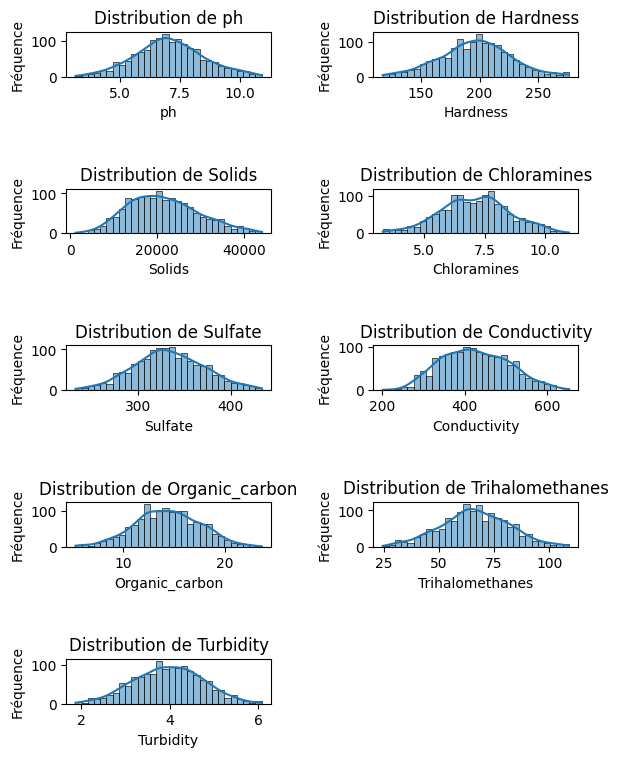

In [26]:
distribution_by_column(dataframe_clean, dataframe_clean.columns)

In [27]:
dataframe_train, dataframe_test, target_train, target_test = train_test_split(dataframe_clean, target, test_size=0.33, random_state=6)
scaler = StandardScaler()
dataframe_train_standard = scaler.fit_transform(dataframe_train, target_train)
dataframe_test_standard = scaler.fit_transform(dataframe_test, target_train)
dataframe_train_standard

array([[ 0.54213351, -0.56216786,  0.80098601, ..., -0.55476156,
        -0.8565703 , -0.88154687],
       [-0.97075563, -0.39552646, -0.22971679, ...,  1.64745988,
         0.16623748, -0.74421493],
       [-2.02391216, -1.53584809, -0.09031092, ...,  0.53245234,
         0.16394837, -0.53910701],
       ...,
       [-0.35437532, -0.11558793, -0.83494387, ...,  0.92644311,
        -0.81090816, -1.55347412],
       [-1.49945431,  0.82562457, -0.02842316, ..., -0.67497582,
        -1.27110386,  0.63319031],
       [ 0.02847672,  0.1830312 , -0.39375648, ..., -1.82000402,
        -1.04971734,  1.01376907]], shape=(939, 9))

In [28]:
xgboost = XGBClassifier()
xgboost.fit(dataframe_train_standard, target_train)
predictions = xgboost.predict(dataframe_test_standard)

In [29]:
def evaluate_model(
    predictions, target_test
) -> None:

    print(f"La matrice de confusion : {confusion_matrix(target_test, predictions)}")
    print(f"La moyenne : {accuracy_score(target_test, predictions)}")
    print(f"La précision : {precision_score(target_test, predictions)}")
    print(f"La sensibilité : {recall_score(target_test, predictions)}")
    print(f"La moyenne harmonique : {f1_score(target_test, predictions)}")

evaluate_model(predictions, target_test)

La matrice de confusion : [[145  91]
 [ 88 139]]
La moyenne : 0.6133909287257019
La précision : 0.6043478260869565
La sensibilité : 0.6123348017621145
La moyenne harmonique : 0.6083150984682714


In [30]:
param_test = {
  'n_estimators' : [400, 500],
  'max_depth': range(2, 15, 5),
  'learning_rate': [0.3, 0.4, 0.5]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(), 
 param_grid = param_test, scoring='f1',n_jobs=4, cv=3)
gsearch2.fit(dataframe_train_standard, target_train)
print(gsearch2.best_params_) 
print(gsearch2.best_score_) 

{'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 400}
0.5791161373685646


In [31]:
xgboost = XGBClassifier(objective= 'binary:logistic', nthread=4, learning_rate=0.3, max_depth=12, n_estimators=400)
xgboost.fit(dataframe_train_standard, target_train)
predictions = xgboost.predict(dataframe_test_standard)
evaluate_model(predictions, target_test)

La matrice de confusion : [[156  80]
 [ 84 143]]
La moyenne : 0.6457883369330454
La précision : 0.6412556053811659
La sensibilité : 0.6299559471365639
La moyenne harmonique : 0.6355555555555555
